# COMP4318/5318 Assignment 2: Image Classification

### Group number: 169, SID1: 520463341, SID2: 520494068

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import tensorflow as tf

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [17]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

Exploration and Visualisation of original data:

X_train shape: (32000, 28, 28, 3)
y_train shape: (32000,)
X_test shape: (8000, 28, 28, 3)
y_test shape: (8000,)
Data type: uint8


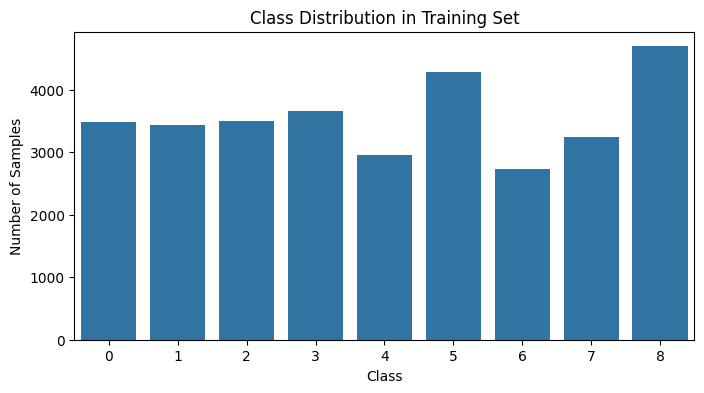

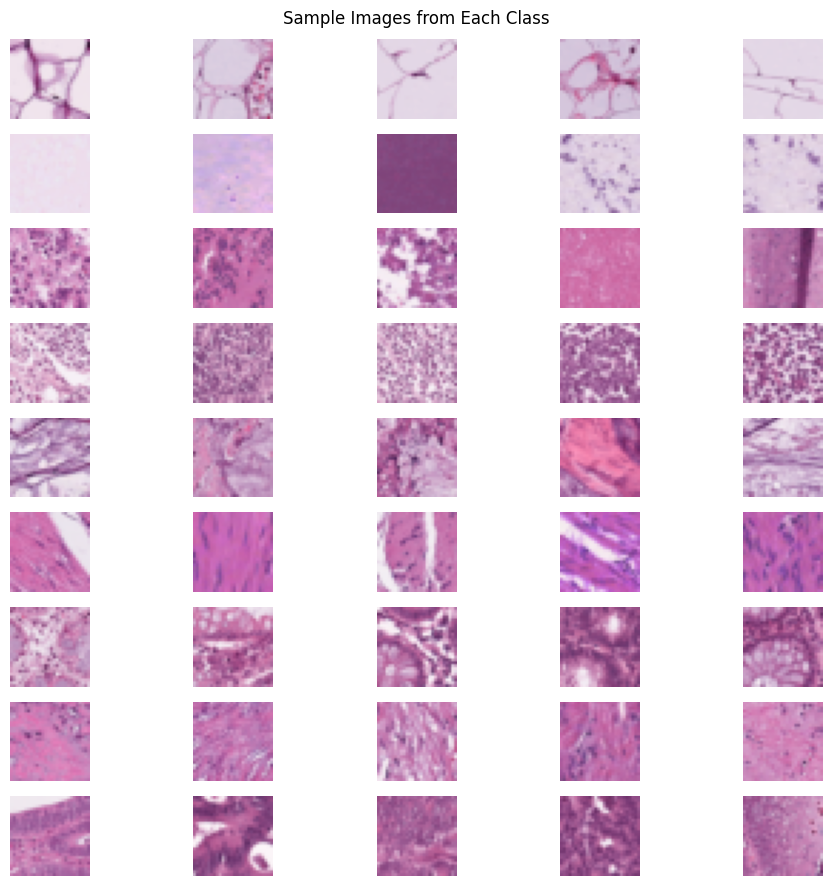

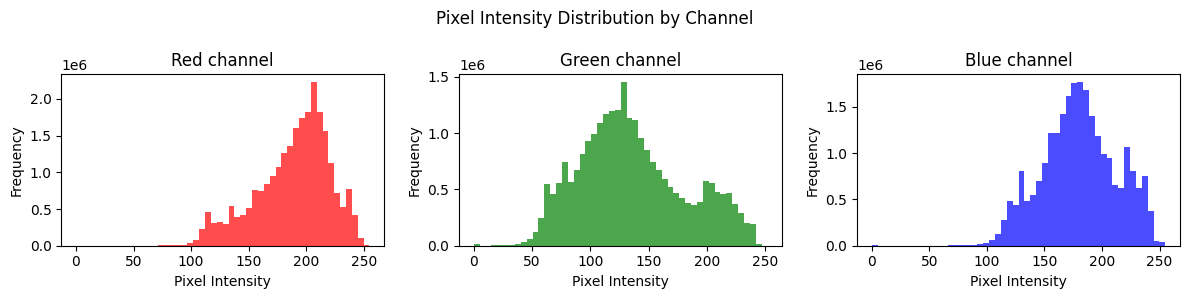

In [18]:
# Summary of shapes and types
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Data type:", X_train.dtype)

# Plot class distribution - if imbalanced, consider class weighting or oversampling
unique_classes, class_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 4))
sns.barplot(x=unique_classes, y=class_counts)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

# Plot example images from each class - if blurry, consider resizing
def plot_examples_by_class(X, y, classes=9):
    fig, axes = plt.subplots(classes, 5, figsize=(10, 9))
    for class_id in range(classes):
        class_indices = np.where(y == class_id)[0][:5]
        for i, idx in enumerate(class_indices):
            ax = axes[class_id, i]
            ax.imshow(X[idx])
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(f"Class {class_id}", rotation=0, labelpad=20, va='center')
    plt.suptitle("Sample Images from Each Class")
    plt.tight_layout()
    plt.show()

plot_examples_by_class(X_train, y_train)

# Plot pixel intensity histogram for RGB channels
def plot_intensity_histograms(X):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    colors = ['red', 'green', 'blue']
    for i in range(3):
        pixel_values = X[:, :, :, i].flatten()
        axes[i].hist(pixel_values, bins=50, color=colors[i], alpha=0.7)
        axes[i].set_title(f'{colors[i].capitalize()} channel')
        axes[i].set_xlabel('Pixel Intensity')
        axes[i].set_ylabel('Frequency')
    plt.suptitle("Pixel Intensity Distribution by Channel")
    plt.tight_layout()
    plt.show()

plot_intensity_histograms(X_train)

Preprocessing:

In [19]:
def preprocess_images(X):
    """
    Normalize image pixel values to range [0, 1].
    Images are originally in uint8 format [0, 255].
    """
    X_norm = X.astype('float32') / 255.0
    return X_norm

# Did not use one-hot encoding because of sparse categorical crossentropy loss function

# Normalize images
X_train_proc = preprocess_images(X_train)
X_test_proc = preprocess_images(X_test)

# Keep original y labels (integers from 0–8)
y_train_proc = y_train
y_test_proc = y_test

# Subset the data for faster training
X_train_proc = X_train_proc[:100]
y_train_proc = y_train_proc[:100]


### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

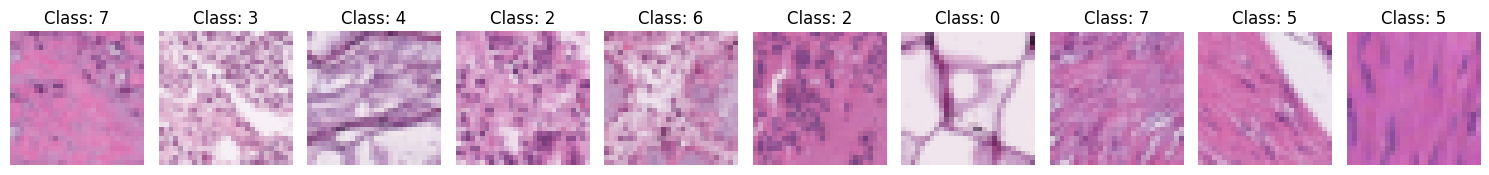

In [20]:
def show_preprocessed_examples(X_proc, y_proc, num=10):
    """
    Display a few normalized images with their class labels.
    """
    fig, axes = plt.subplots(1, num, figsize=(15, 2))
    for i in range(num):
        axes[i].imshow(X_proc[i])
        axes[i].axis('off')
        axes[i].set_title(f"Class: {y_proc[i]}")
    plt.tight_layout()

show_preprocessed_examples(X_train_proc, y_train_proc)

## 2. Algorithm design and setup

### k-Nearest Neighbors

In [21]:
# Use default k=3 for initial setup; will tune later
initial_knn_model = KNeighborsClassifier(n_neighbors=3)

### Fully connected neural network

In [22]:
def build_mlp(hidden_units1=512, hidden_units2=256, learning_rate=1e-3, optimizer='adam'):
    """
    Builds a shallow 2-layer MLP for image classification on 28x28 RGB inputs.
    """
    # Choose optimizer with specified learning rate
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model = keras.models.Sequential([
        keras.layers.Input(shape=(28, 28, 3)), # Input layer for 28x28 RGB images
        keras.layers.Flatten(), # Flatten image into 1D array
        keras.layers.Dense(hidden_units1, activation='relu'), # First hidden layer
        keras.layers.Dropout(0.3), # Dropout for regularisation, helps prevent overfitting and
        keras.layers.Dense(hidden_units2, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(9, activation='softmax') # Number of classes is 9
    ])
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # loss='sparse_categorical_crossentropy' for integer labels
    return model

### Convolutional neural network

In [23]:
def build_cnn(num_filters=32, dropout_rate=0.5, learning_rate=1e-3, optimizer='adam'):
    """
    Builds a simple CNN with two convolutional blocks and one dense output layer.
    """
    # Choose optimizer with specified learning rate
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model = keras.Sequential([
        keras.Input(shape=(28, 28, 3)), # Input layer for 28x28 RGB images

        # First convolutional block
        keras.layers.Conv2D(num_filters, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(dropout_rate),

        # Second convolutional block
        keras.layers.Conv2D(num_filters * 2, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(dropout_rate),

        # Fully connected classification layers
        keras.layers.Flatten(),
        keras.layers.Dense(num_filters * 4, activation='relu'), # Dense layer with more units
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(9, activation='softmax') # Output layer for 9 classes
    ])
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## 3. Hyperparameter tuning

### k-Nearest Neighbors

In [24]:
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'], # All equal or inverse distance
    'p': [1, 2]  # Manhattan and Euclidean distances
}

# Flatten image data for k-NN which requires 2D input (samples x features)
X_train_flat = X_train_proc.reshape(X_train_proc.shape[0], -1)
X_test_flat = X_test_proc.reshape(X_test_proc.shape[0], -1)


# Run grid search for k-NN using 3-fold cross-validation
start = time.time()
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3, scoring='accuracy', n_jobs=1, verbose=3) # Set verbose=3 to keep track of runtime for each combination
knn_grid.fit(X_train_flat, y_train_proc)
end = time.time()

print("k-NN best params:", knn_grid.best_params_)
print("k-NN best score:", knn_grid.best_score_)
print("k-NN runtime:", end - start, "seconds")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END n_neighbors=1, p=1, weights=uniform;, score=0.294 total time=   0.0s
[CV 2/3] END n_neighbors=1, p=1, weights=uniform;, score=0.303 total time=   0.0s
[CV 3/3] END n_neighbors=1, p=1, weights=uniform;, score=0.212 total time=   0.0s
[CV 1/3] END n_neighbors=1, p=1, weights=distance;, score=0.294 total time=   0.0s
[CV 2/3] END n_neighbors=1, p=1, weights=distance;, score=0.303 total time=   0.0s
[CV 3/3] END n_neighbors=1, p=1, weights=distance;, score=0.212 total time=   0.0s
[CV 1/3] END n_neighbors=1, p=2, weights=uniform;, score=0.265 total time=   0.0s
[CV 2/3] END n_neighbors=1, p=2, weights=uniform;, score=0.212 total time=   0.0s
[CV 3/3] END n_neighbors=1, p=2, weights=uniform;, score=0.182 total time=   0.0s
[CV 1/3] END n_neighbors=1, p=2, weights=distance;, score=0.265 total time=   0.0s
[CV 2/3] END n_neighbors=1, p=2, weights=distance;, score=0.212 total time=   0.0s
[CV 3/3] END n_neighbors=1, p=2,

### Fully connected neural network

In [25]:
mlp_grid = {
    'model__hidden_units1': [256, 512], # First hidden layer size
    'model__hidden_units2': [128, 256], # Second hidden layer size
    'model__learning_rate': [1e-2, 1e-3],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [5],
    'batch_size': [32, 64],
}

# Wrap the MLP model for scikit-learn compatibility
mlp_wrapper = KerasClassifier(model=build_mlp, verbose=0, random_state=42) # Set random_state for reproducibility

# Run grid search for MLP using 3-fold CV
start = time.time()
mlp_search = GridSearchCV(estimator=mlp_wrapper, param_grid=mlp_grid, cv=3, n_jobs=1, verbose=3)
mlp_search.fit(X_train_proc, y_train_proc)
end = time.time()

print("MLP best params:", mlp_search.best_params_)
print("MLP best score:", mlp_search.best_score_)
print("MLP runtime:", end - start, "seconds")

Fitting 3 folds for each of 32 candidates, totalling 96 fits


2025-05-11 12:51:23.244271: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-11 12:51:23.244646: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.118 total time=   1.0s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.121 total time=   0.8s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.091 total time=   0.7s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.118 total time=   0.7s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.121 total time=   0.7s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.091 total time=   0.7s
[

2025-05-11 12:51:28.327153: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-11 12:51:28.327487: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.121 total time=   0.7s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.152 total time=   0.7s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.206 total time=   0.7s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   0.6s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.152 total time=   0.6s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.088 total time=   0

2025-05-11 12:51:33.356305: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-11 12:51:33.356629: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.088 total time=   0.6s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.152 total time=   0.6s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.121 total time=   0.6s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.001, optimizer=adam;, score=0.176 total time=   0.6s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.001, optimizer=adam;, score=0.091 total time=   0.6s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.001, optimizer=adam;, score=0.121 total time=   0.6

2025-05-11 12:51:38.645631: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:51:38.646025: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   0.6s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.088 total time=   0.6s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.121 total time=   0.6s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.121 total time=   0.6s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.088 total time=   0.7s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.121 total time=   0.6s


2025-05-11 12:51:43.680444: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-11 12:51:43.681527: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.121 total time=   2.5s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.176 total time=   0.7s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.121 total time=   0.6s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.091 total time=   0.6s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.176 total time=   0.6s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   0

2025-05-11 12:51:48.825184: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:51:48.825501: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.118 total time=   0.6s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.091 total time=   0.6s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.061 total time=   0.6s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.118 total time=   0.6s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.091 total time=   1.0s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.061 total time=   0.9s
[

2025-05-11 12:51:53.895584: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:51:53.895928: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.001, optimizer=adam;, score=0.121 total time=   0.7s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.001, optimizer=adam;, score=0.121 total time=   0.7s
[CV 1/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.088 total time=   0.7s
[CV 2/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   0.6s
[CV 3/3] END batch_size=32, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   0.7s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.088 total time=   0

2025-05-11 12:51:59.406486: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:51:59.406829: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.091 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.091 total time=   0.7s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.088 total time=   0.6s
[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.121 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.091 total time=   0.6s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.088 total time=   0.

2025-05-11 12:52:04.589092: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:04.589423: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.030 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.182 total time=   0.6s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.176 total time=   0.6s
[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.030 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.182 total time=   0.6s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.001, optimizer=adam;, score=0.118 total time=   0.6s


2025-05-11 12:52:09.847095: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:09.847416: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=256, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.091 total time=   0.6s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.088 total time=   0.6s
[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.121 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=adam;, score=0.091 total time=   0.6s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.01, optimizer=rmsprop;, score=0.088 total time=   0.6s

2025-05-11 12:52:15.225317: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:15.225654: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.152 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=adam;, score=0.121 total time=   0.6s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.265 total time=   0.6s
[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.152 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=128, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   2.5s


2025-05-11 12:52:20.262794: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:20.263610: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.088 total time=   0.7s
[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.091 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=adam;, score=0.121 total time=   0.7s
[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.088 total time=   0.6s
[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.091 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.01, optimizer=rmsprop;, score=0.121 total time=   0.6s
[

2025-05-11 12:52:25.327233: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-11 12:52:25.327580: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.088 total time=   0.6s
[CV 2/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   0.6s
[CV 3/3] END batch_size=64, epochs=5, model__hidden_units1=512, model__hidden_units2=256, model__learning_rate=0.001, optimizer=rmsprop;, score=0.121 total time=   0.6s
MLP best params: {'batch_size': 64, 'epochs': 5, 'model__hidden_units1': 512, 'model__hidden_units2': 128, 'model__learning_rate': 0.001, 'optimizer': 'adam'}
MLP best score: 0.179144385026738
MLP runtime: 64.57972192764282 seconds


### Convolutional neural network

In [26]:
cnn_grid = {
    'model__num_filters': [32, 64], # Number of filters in first conv layer
    'model__dropout_rate': [0.3, 0.5], # Dropout rate to reduce overfitting
    'model__learning_rate': [1e-3, 5e-4],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10],
    'batch_size': [32, 64],
}

# Wrap the CNN model for compatibility with GridSearchCV
cnn_wrapper = KerasClassifier(model=build_cnn, verbose=0, random_state=42)

# Run grid search for CNN using 3-fold CV
start = time.time()
cnn_search = GridSearchCV(estimator=cnn_wrapper, param_grid=cnn_grid, cv=3, n_jobs=1, verbose=3)
cnn_search.fit(X_train_proc, y_train_proc)
end = time.time()

print("CNN best params:", cnn_search.best_params_)
print("CNN best score:", cnn_search.best_score_)
print("CNN runtime:", end - start, "seconds")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.265 total time=   0.9s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.091 total time=   0.9s


2025-05-11 12:52:30.414536: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-11 12:52:30.414860: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.265 total time=   0.9s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.091 total time=   0.9s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.206 total time=   1.0s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.121 total time=   1.1s


2025-05-11 12:52:36.076320: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:36.076638: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.182 total time=   1.0s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.206 total time=   1.0s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.121 total time=   1.0s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.182 total time=   1.1s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.176 total time=   0.9s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s


2025-05-11 12:52:41.826128: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:41.826460: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.176 total time=   0.9s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.206 total time=   1.0s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.152 total time=   1.0s


2025-05-11 12:52:47.566379: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:47.566710: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.091 total time=   1.1s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.206 total time=   1.0s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.152 total time=   1.0s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.091 total time=   1.0s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.176 total time=   1.4s


2025-05-11 12:52:52.965595: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:52.965946: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.176 total time=   0.9s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.235 total time=   1.0s


2025-05-11 12:52:58.719479: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:52:58.719814: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.121 total time=   1.1s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.091 total time=   1.1s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.235 total time=   1.0s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.121 total time=   1.1s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.091 total time=   1.0s


2025-05-11 12:53:03.859280: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:03.859620: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.235 total time=   1.0s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s


2025-05-11 12:53:09.046861: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:09.047264: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.235 total time=   3.4s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.176 total time=   1.1s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.121 total time=   1.1s


2025-05-11 12:53:14.131941: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:14.132276: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.091 total time=   1.0s
[CV 1/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.176 total time=   1.1s
[CV 2/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.121 total time=   1.1s
[CV 3/3] END batch_size=32, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.091 total time=   1.1s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.088 total time=   0.9s


2025-05-11 12:53:19.215868: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:19.216218: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.091 total time=   0.9s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.091 total time=   0.9s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.088 total time=   0.9s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.091 total time=   0.9s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.091 total time=   0.9s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.235 total time=   1.0s


2025-05-11 12:53:24.617546: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:24.617898: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.091 total time=   1.0s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.121 total time=   1.0s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.235 total time=   1.0s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.091 total time=   1.0s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.121 total time=   1.0s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.088 total time=   0.8s


2025-05-11 12:53:30.203675: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:30.204046: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.8s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.088 total time=   0.8s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.8s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.8s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.206 total time=   1.0s


2025-05-11 12:53:35.644380: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:35.644703: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.152 total time=   1.1s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.091 total time=   1.2s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.206 total time=   1.1s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.152 total time=   1.0s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.3, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.091 total time=   1.0s


2025-05-11 12:53:40.840733: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:40.841091: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.088 total time=   0.9s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=adam;, score=0.061 total time=   0.9s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.088 total time=   0.8s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=32, optimizer=rmsprop;, score=0.061 total time=   0.9s


2025-05-11 12:53:46.144684: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:46.145028: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.176 total time=   1.0s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.061 total time=   1.0s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=adam;, score=0.091 total time=   1.0s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.176 total time=   1.0s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.061 total time=   1.0s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.001, model__num_filters=64, optimizer=rmsprop;, score=0.091 total time=   1.0s


2025-05-11 12:53:52.089913: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:52.090228: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.235 total time=   1.1s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=adam;, score=0.121 total time=   0.9s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.235 total time=   0.9s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=32, optimizer=rmsprop;, score=0.121 total time=   0.9s


2025-05-11 12:53:57.423162: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-11 12:53:57.423468: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.147 total time=   1.0s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.121 total time=   1.0s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=adam;, score=0.091 total time=   1.0s
[CV 1/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.147 total time=   1.0s
[CV 2/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.121 total time=   1.0s
[CV 3/3] END batch_size=64, epochs=10, model__dropout_rate=0.5, model__learning_rate=0.0005, model__num_filters=64, optimizer=rmsprop;, score=0.091 total time=   1.0s


2025-05-11 12:54:02.449654: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-11 12:54:02.449993: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

CNN best params: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__num_filters': 64, 'optimizer': 'adam'}
CNN best score: 0.16963755199049316
CNN runtime: 95.79374313354492 seconds


### Saving and Visualising Results and Runtimes

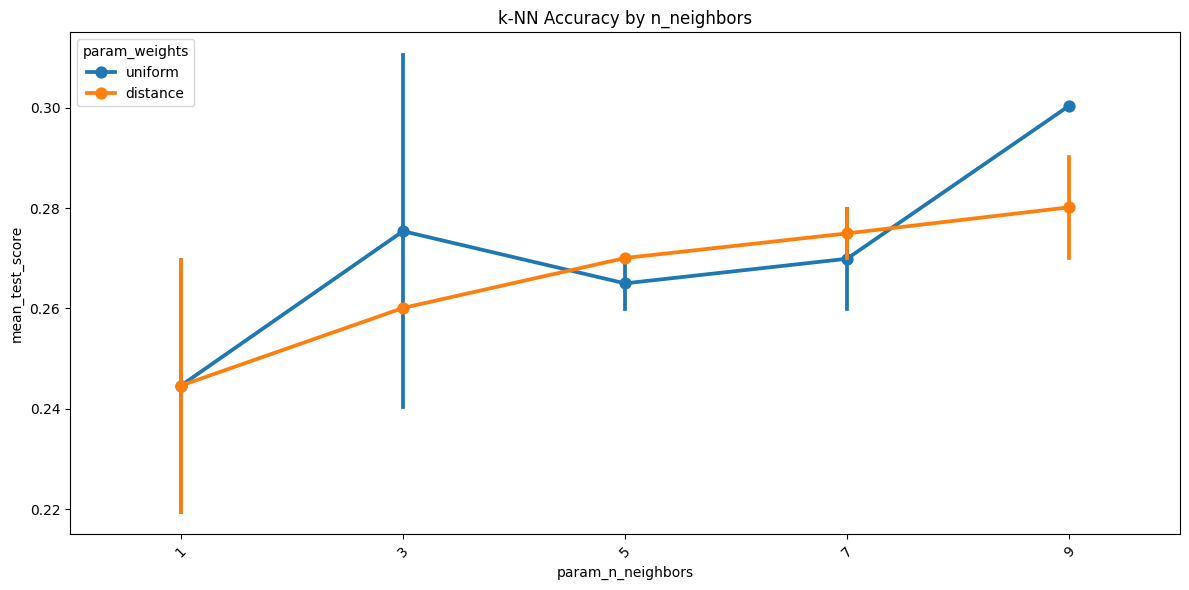

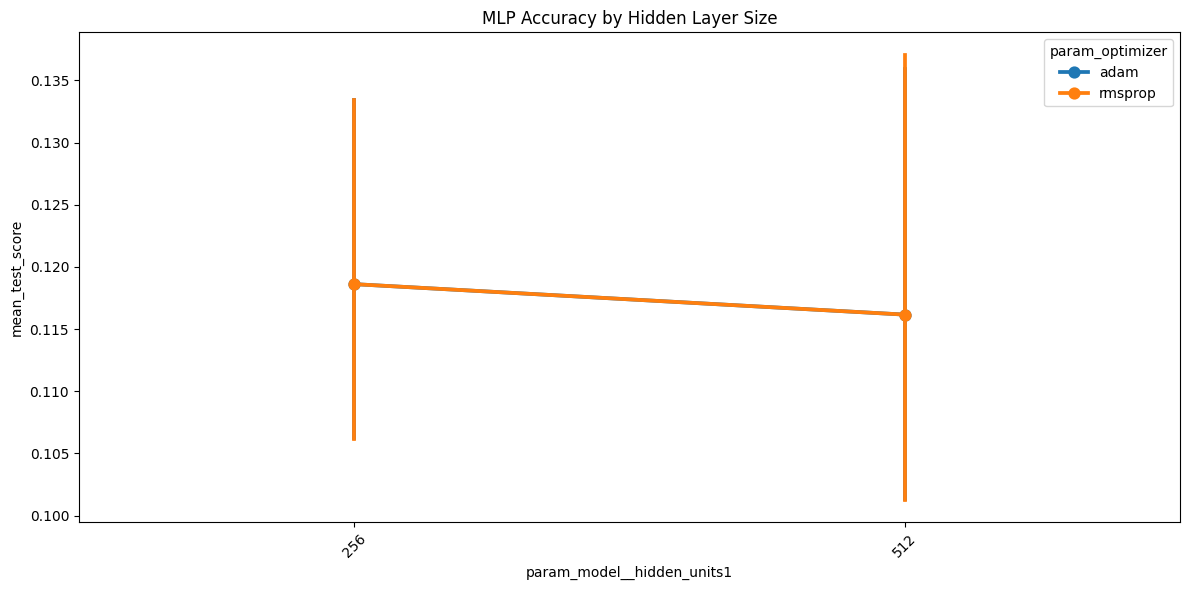

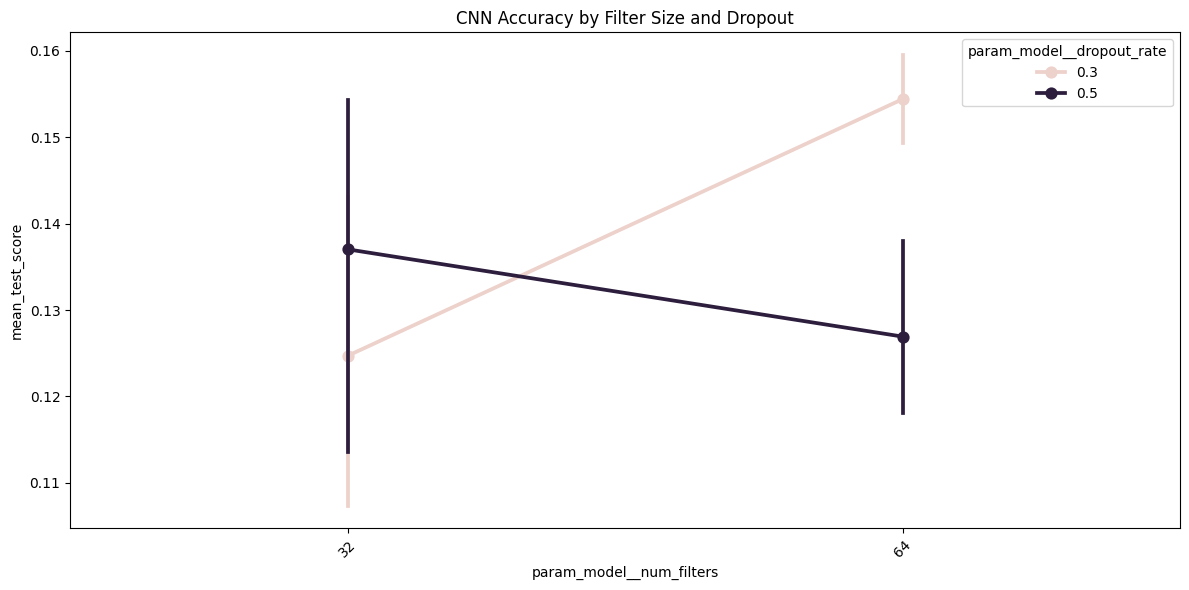

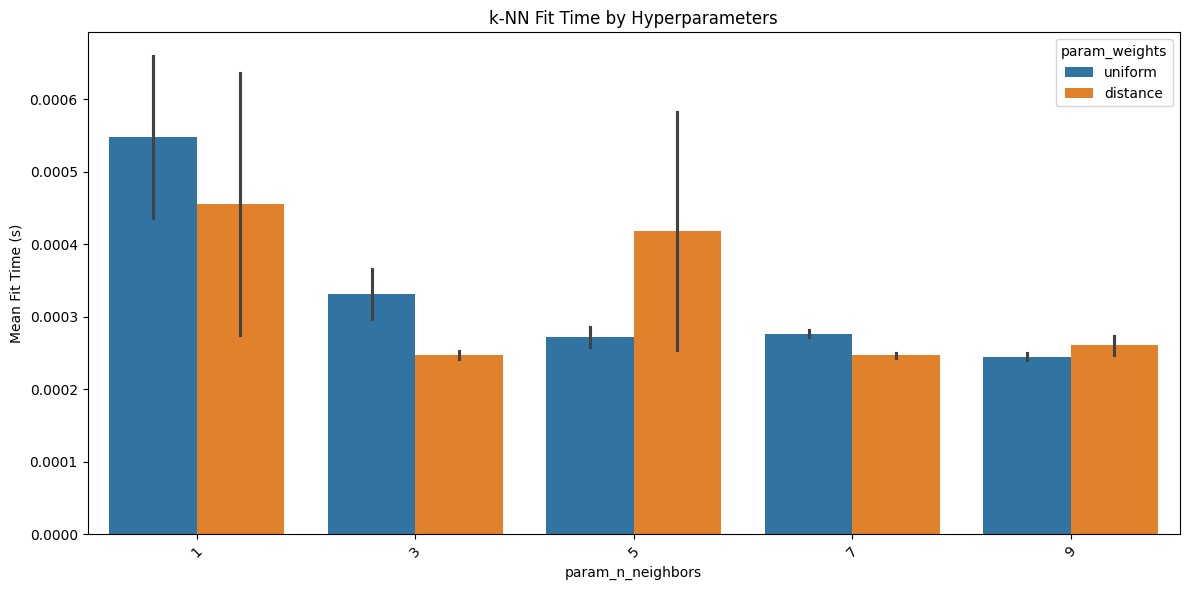

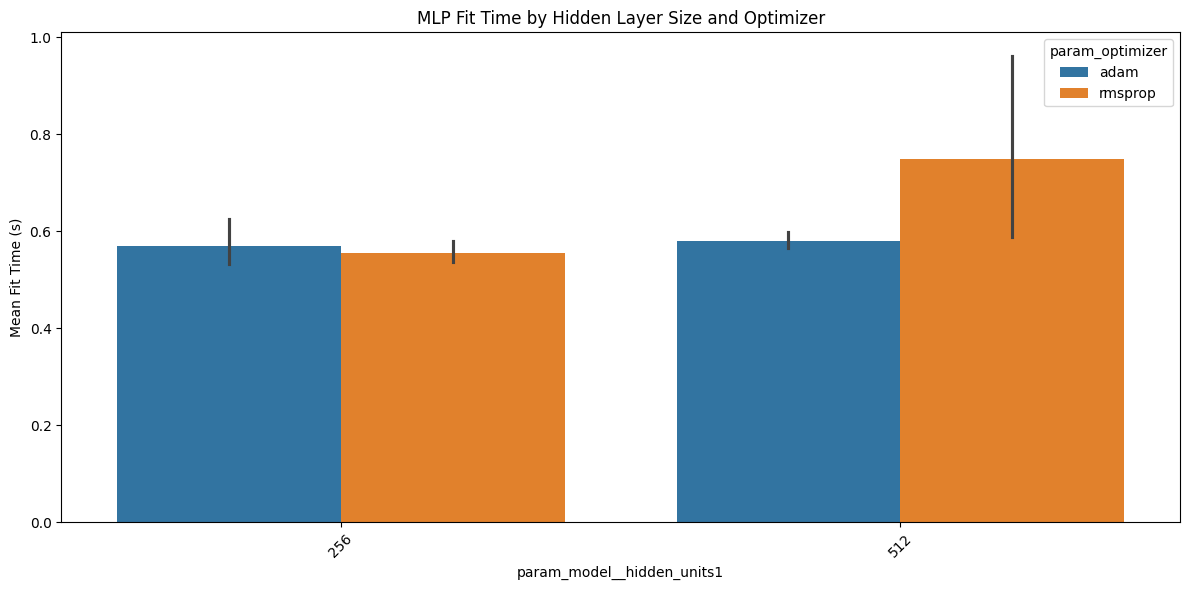

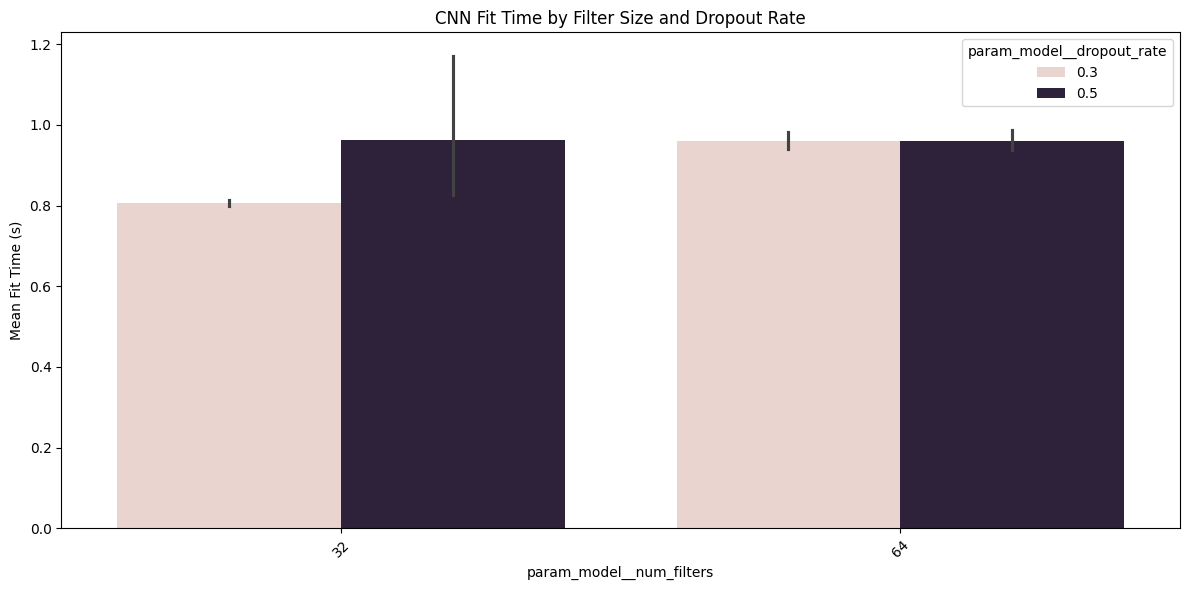

,model,mean_fit_time,mean_score_time,mean_test_score,index
13,cnn,1.671068,0.074897,0.159239,13
9,mlp,1.204472,0.060783,0.110220,9
27,mlp,1.192251,0.045630,0.179144,27
15,cnn,1.021389,0.079422,0.129531,15
22,cnn,1.020541,0.061103,0.149436,22
...,...,...,...,...,...
18,knn,0.000250,0.005145,0.300357,18
17,knn,0.000248,0.005859,0.290255,17
15,knn,0.000243,0.004798,0.270053,15
5,knn,0.000242,0.005675,0.260250,5


In [ ]:
def extract_gridsearch_results(grid, model_name="model"):
    """
    Extracts results from GridSearchCV and returns a DataFrame.
    Includes hyperparameters, mean score, std, fit time, and rank.
    """
    results = pd.DataFrame(grid.cv_results_)
    results["model"] = model_name
    return results

def plot_top_hyperparams(results_df, x_param, y_param="mean_test_score", hue_param=None, title=""):
    """
    Visualises the performance (mean test score) across hyperparameter combinations.
    """
    plt.figure(figsize=(12, 6))
    sns.pointplot(data=results_df.sort_values(by=y_param, ascending=False), x=x_param, y=y_param, hue=hue_param)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_fit_times(results_df, x_param, hue_param=None, title=""):
    """
    Plots mean fit time to compare training efficiency across hyperparameters.
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df.sort_values(by="mean_fit_time", ascending=False),
                x=x_param, y="mean_fit_time", hue=hue_param)
    plt.title(title)
    plt.ylabel("Mean Fit Time (s)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def runtime_table(*dfs):
    """
    Combines runtime-related stats (fit time, score time, accuracy) from multiple model result DataFrames.
    """
    table = pd.concat([
        df[["model", "mean_fit_time", "mean_score_time", "mean_test_score"]].assign(index=range(len(df)))
        for df in dfs
    ])
    return table.sort_values(by="mean_fit_time", ascending=False) # Sort by fit time

# Extract and tag results for each model
knn_results_df = extract_gridsearch_results(knn_grid, "knn")
mlp_results_df = extract_gridsearch_results(mlp_search, "mlp")
cnn_results_df = extract_gridsearch_results(cnn_search, "cnn")

# Save results for reproducibility and reporting
knn_results_df.to_csv("knn_results.csv", index=False)
mlp_results_df.to_csv("mlp_results.csv", index=False)
cnn_results_df.to_csv("cnn_results.csv", index=False)

# Plot accuracy vs key hyperparameters for each model
plot_top_hyperparams(knn_results_df, x_param="param_n_neighbors", hue_param="param_weights", title="k-NN Accuracy by n_neighbors")
plot_top_hyperparams(mlp_results_df, x_param="param_model__hidden_units1", hue_param="param_optimizer", title="MLP Accuracy by Hidden Layer Size")
plot_top_hyperparams(cnn_results_df, x_param="param_model__num_filters", hue_param="param_model__dropout_rate", title="CNN Accuracy by Filter Size and Dropout")

# Plot fit time vs key hyperparameters for each model
plot_fit_times(knn_results_df, x_param="param_n_neighbors", hue_param="param_weights", title="k-NN Fit Time by Hyperparameters")
plot_fit_times(mlp_results_df, x_param="param_model__hidden_units1", hue_param="param_optimizer", title="MLP Fit Time by Hidden Layer Size and Optimizer")
plot_fit_times(cnn_results_df, x_param="param_model__num_filters", hue_param="param_model__dropout_rate", title="CNN Fit Time by Filter Size and Dropout Rate")

# Display combined runtime and accuracy summary across all models
runtime_summary = runtime_table(knn_results_df, mlp_results_df, cnn_results_df)
display(runtime_summary)

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### k-Nearest Neighbors

In [28]:
# Train the final k-NN model using the best hyperparameters
start = time.time()
final_knn = KNeighborsClassifier(n_neighbors=3, p=1, weights='uniform')
final_knn.fit(X_train_flat, y_train_proc)
knn_train_time = time.time() - start

# Predict on the test set and measure test time
start = time.time()
y_knn_pred = final_knn.predict(X_test_flat)
knn_test_time = time.time() - start

# Compute and print accuracy and classification report
knn_acc = accuracy_score(y_test_proc, y_knn_pred)
print("k-NN Test Accuracy:", knn_acc)
print("k-NN Train Time:", knn_train_time, "s | Test Time:", knn_test_time, "s")
print("k-NN Classification Report:\n", classification_report(y_test_proc, y_knn_pred))

k-NN Test Accuracy: 0.29625
k-NN Train Time: 0.001322031021118164 s | Test Time: 0.5117499828338623 s
k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.97      0.76       873
           1       0.07      0.01      0.02       858
           2       0.16      0.67      0.26       877
           3       0.47      0.25      0.33       914
           4       0.39      0.15      0.21       737
           5       0.39      0.18      0.24      1072
           6       0.38      0.01      0.01       682
           7       0.11      0.02      0.04       813
           8       0.25      0.32      0.28      1174

    accuracy                           0.30      8000
   macro avg       0.32      0.29      0.24      8000
weighted avg       0.32      0.30      0.25      8000



### Fully connected neural network

In [29]:
# Set TensorFlow seed for reproducibility and to satisfy determinism requirement
tf.random.set_seed(42)
                   
# Train the final MLP model using the best hyperparameters
start = time.time()
final_mlp = build_mlp(hidden_units1=512, hidden_units2=256, learning_rate=0.01, optimizer='rmsprop')
final_mlp.fit(X_train_proc, y_train_proc, batch_size=32, epochs=5, validation_split=0.1, verbose=0)
mlp_train_time = time.time() - start

# Evaluate the MLP model on the test set
start = time.time()
mlp_test_loss, mlp_test_acc = final_mlp.evaluate(X_test_proc, y_test_proc, verbose=0)
mlp_test_time = time.time() - start

print("MLP Test Accuracy:", mlp_test_acc)
print("MLP Train Time:", mlp_train_time, "s | Test Time:", mlp_test_time, "s")

MLP Test Accuracy: 0.14662499725818634
MLP Train Time: 0.7072210311889648 s | Test Time: 0.2573671340942383 s


### Convolutional neural network

In [ ]:
# Set TensorFlow seed for reproducibility and to satisfy determinism requirement
tf.random.set_seed(42)

# Train the final CNN model using the best hyperparameters
start = time.time()
final_cnn = build_cnn(num_filters=64, dropout_rate=0.3, learning_rate=0.001, optimizer='adam')
final_cnn.fit(X_train_proc, y_train_proc, batch_size=32, epochs=10, validation_split=0.1, verbose=0)
cnn_train_time = time.time() - start


# Evaluate the CNN model on the test set
start = time.time()
cnn_test_loss, cnn_test_acc = final_cnn.evaluate(X_test_proc, y_test_proc, verbose=0)
cnn_test_time = time.time() - start

print("CNN Test Accuracy:", cnn_test_acc)
print("CNN Train Time:", cnn_train_time, "s | Test Time:", cnn_test_time, "s")

2025-05-11 12:54:09.416726: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-11 12:54:09.417130: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

CNN Test Accuracy: 0.23199999332427979
CNN Train Time: 4.338298082351685 s | Test Time: 0.8379349708557129 s


### Storing Results

In [31]:
results_table = pd.DataFrame({
    "Model": ["k-NN", "MLP", "CNN"],
    "Test Accuracy": [knn_acc, mlp_test_acc, cnn_test_acc],
    "Train Time (s)": [knn_train_time, mlp_train_time, cnn_train_time],
    "Test Time (s)": [knn_test_time, mlp_test_time, cnn_test_time]
})
print(results_table)

  Model  Test Accuracy  Train Time (s)  Test Time (s)
0  k-NN       0.296250        0.001322       0.511750
1   MLP       0.146625        0.707221       0.257367
2   CNN       0.232000        4.338298       0.837935


### Confusion Matrices

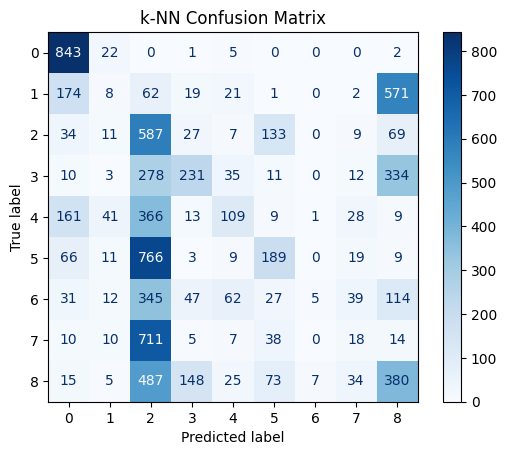

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


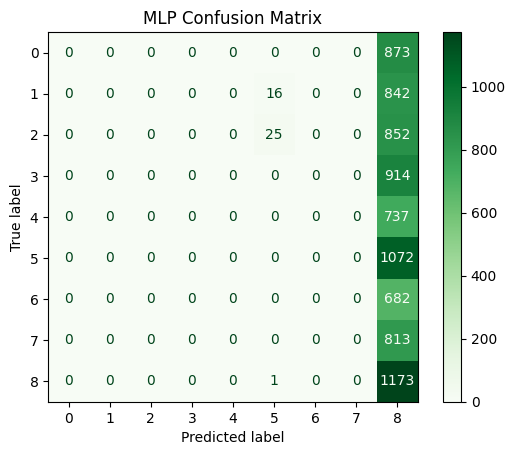

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


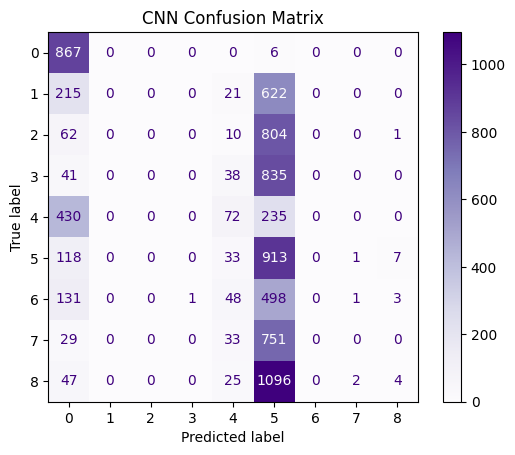

In [32]:
# k-NN Confusion Matrix
cm_knn = confusion_matrix(y_test_proc, y_knn_pred)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot(cmap='Blues')
plt.title("k-NN Confusion Matrix")
plt.show()

# MLP Confusion Matrix
y_mlp_pred = np.argmax(final_mlp.predict(X_test_proc), axis=1)
cm_mlp = confusion_matrix(y_test_proc, y_mlp_pred)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp_mlp.plot(cmap='Greens')
plt.title("MLP Confusion Matrix")
plt.show()

# CNN Confusion Matrix
y_cnn_pred = np.argmax(final_cnn.predict(X_test_proc), axis=1)
cm_cnn = confusion_matrix(y_test_proc, y_cnn_pred)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn)
disp_cnn.plot(cmap='Purples')
plt.title("CNN Confusion Matrix")
plt.show()